# 1. Precision and Recall value of different models

In [2]:
import json,os,jieba
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import _pickle as cPickle
import seaborn as sns
import scipy.stats as stats
import matplotlib.ticker as ticker

In [3]:
queryroot="./annot"
tok2id_p="./idftab/tok2id.json"
idftab_p="./idftab/idftab.json"
query_p="query.json"

def create_df(annot_pos): 
    df = pd.DataFrame({'score': np.array(annot_pos)}) 
    return df 

dirs=os.listdir(queryroot)
corpus_p="./corpus_q_jieba.json"
with open(corpus_p,"r",encoding="utf-8") as fr:
    qcorpus=json.load(fr)
with open(tok2id_p,"r",encoding="utf-8") as fr:
    tok2idtab=json.load(fr)
with open(idftab_p,"r",encoding="utf-8") as fr:
    idftab=json.load(fr)

# 如果去除停用词的话
stopword_p="stopword.txt"
with open(stopword_p, 'r',encoding="utf-8") as g:
    words = g.readlines() #stop words
stopwords = [i.strip() for i in words]
qdict={}
with open(query_p,'r',encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        entry=eval(line)
        rid=entry["ridx"]
        qdict[rid]=entry["q"]

puncset={'”','“','.','（','）','-','：','、','㈠', '［', '×', '］', '／', '㈥', '.', '㈢', '《', '＊', '，', '㈡', '。', '》', '；', '㈤', '㈣', '？',"／"}

In [4]:
def cutbins(values,bins,labels):
    resls=[0 for _ in range(len(labels))]
    for v in values:
        for idx in list(range(len(bins)))[:-1]:
            low=bins[idx]
            uper=bins[idx+1]
            if v>= low and v<uper:
                resls[idx]+=1
    return resls

def ncutbins(values,bins,labels):
    '''
        normalize using annotation words
    '''
    resls=[0 for _ in range(len(labels))]
    for v in values:
        for idx in list(range(len(bins)))[:-1]:
            low=bins[idx]
            uper=bins[idx+1]
            if v>= low and v<uper:
                resls[idx]+=1
    nresls=[]
    for v in resls:
        nresls.append(v/len(values)) #排名列表
    return nresls

def ntotal_cutbins(values,bins,labels,qwords):
    '''
        normalize to get the ratio using query words
    '''
    resls=[0 for _ in range(len(labels))]
    for v in values:
        for idx in list(range(len(bins)))[:-1]:
            low=bins[idx]
            uper=bins[idx+1]
            if v>= low and v<uper:
                resls[idx]+=1
    nresls=[]
    normalized_v=qwords/(len(bins)-1)
    print(qwords)
    for v in resls:
        nresls.append(v/normalized_v) #排名列表
    return nresls


In [5]:
def generate(xls,yls):
    '''
        generate the distribution line using plots
    '''
    xnew=[]
    ynew=[]
    for idx,x in enumerate(xls):
        if idx==0 or idx==len(xls)-1:
            xnew.append(x)
        else:
            for i in range(2):
                xnew.append(x)
    for idx,y in enumerate(yls):
        for i in range(2):
            ynew.append(y)
    return xnew,ynew


# Get the BM25 precision of annotation words

In [6]:
bm25_imp="./bm25_importance/bm25_words_top-1_query_rmstop.json" # 去除停用词
with open(bm25_imp) as fr:
    bm25_imp=json.load(fr)

bm25_dic={}
for qid in bm25_imp:
    bm25items=bm25_imp[qid]
    wdic={}
    for i,v in bm25items:
        if i in wdic:
            print(qid,i)
        wdic[i]=v
    bm25_dic[qid]=wdic

In [7]:
# bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [str(v) for v in bins][1:]
accumulate_rels=[0 for i in range(len(labels))]
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]
        result=annotation.split("<span>")
        spanls=[]
        spanwordls=[] # get the words in the span and directly cut it
        for item in result[1:]:
            itemls=item.split("</span>")
            spanls.append(itemls[0])
            tmp= jieba.cut(itemls[0], cut_all=False) 
            tem = " ".join(tmp).split()
            # 去除标注中的标点
            for ws in tem:
                if ws not in puncset:
                    spanwordls.append(ws)
        spanwordset=set(spanwordls) #注意新分的词语不一定在原本的词语列表中

        # print(len(spanwordset))
        wordls=qcorpus[str(qid)] #wordls是完整的对query分词结果，没有做停用词处理;但是没有标点符号
        ws=Counter(wordls)
        bm25weightspan={}
        bm25weightdic=bm25_dic[str(qid)] #包含bm25对所有词语的重要性
        for tok in ws:
            if tok not in bm25weightdic:
                continue
            bm25weightspan[tok]=bm25weightdic[tok]
            
        rankres=sorted(bm25weightspan.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for idx,entry in enumerate(rankres):
            rankdic[entry[0]]=idx
        annot_pos=[]
        for tok in spanwordset:
            if tok not in rankdic:
                continue
            annot_pos.append(rankdic[tok]/len(rankres))
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ncutbins(annot_pos,bins,labels)
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v
print(accumulate_rels)
accumulate_rels=np.array(accumulate_rels)
BM25_Recall=accumulate_rels/np.sum(accumulate_rels)
## 1. 标注本身的TF-IDF值

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\PC\AppData\Local\Temp\jieba.cache
Loading model cost 0.721 seconds.
Prefix dict has been built successfully.


[15.180615423315379, 10.873473140284224, 12.40442360030756, 10.361971440277445, 12.421821910669385, 10.615458438625584, 9.883566685922045, 9.887391077581265, 9.575994918743572, 5.795283364273513]


# Dense retrieval items

In [8]:
queryroot="./annot"

query_p="query.json"
doc2q_p="./atten_new/doc2q_char.json"
attmap_p="./atten_new/atten_map_6_6.pkl"
query_offset_p="./atten_new/query_offset.pkl"

def create_df(annot_pos): 
    df = pd.DataFrame({'score': np.array(annot_pos)}) 
    return df 

dirs=os.listdir(queryroot)
corpus_p="./corpus_q_jieba.json"
with open(corpus_p,"r",encoding="utf-8") as fr:
    qcorpus=json.load(fr)

with open(doc2q_p,"r",encoding="utf-8") as fr:
    doc2q=json.load(fr) # key为字符串;

with open(attmap_p,"rb") as fr:
    attmap=cPickle.load(fr)

with open(query_offset_p,"rb") as fr:
    query_offset=cPickle.load(fr) # get only the cls token att; get only from CLS to SEP-1;

# 如果去除停用词的话
stopword_p="stopword.txt"
with open(stopword_p, 'r',encoding="utf-8") as g:
    words = g.readlines() #stop words
stopwords = [i.strip() for i in words]
qdict={}
with open(query_p,'r',encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        entry=eval(line)
        rid=entry["ridx"]
        qdict[rid]=entry["q"]

puncset={'”','“','.','（','）','-','：','、','㈠', '［', '×', '］', '／', '㈥', '.', '㈢', '《', '＊', '，', '㈡', '。', '》', '；', '㈤', '㈣', '？',"／"}

In [9]:
def labelgen(annotation):
    # 0为在span外,1为在span内
    result=annotation.split("<span>")
    labels=[]
    tmp=[0 for _ in range(len(result[0]))]
    labels.extend(tmp)
    for item in result[1:]:
        itemls=item.split("</span>")
        tmp=[1 for _ in range(len(itemls[0]))] # 第一个是在<span> </span>中的
        labels.extend(tmp)
        for item in itemls[1:]:
            tmp=[0 for _ in range(len(item))] # 其它不是;
            labels.extend(tmp)
    return labels

def NumIn(s):
    '''
        if numerical in string s 
            return True
    '''
    for char in s:
        if char.isdigit():
            return True
    return False

def wordoffsets(wordls,original):
    '''
        align the char to word,assign words to char offset in original
    '''
    offsetls=[]
    b=0
    for widx,word in enumerate(wordls):
        pos=original.find(word,b)
        if NumIn(word):
            offsetls.append([-1,-1])
            continue
        if pos==-1:
            print("error") #好家伙，所有带小数的都错了;240.2切分成2402的，我真服了..
            print(word) # 也就是说数字会被找错，如果是数字就不找了!
            print("last word:{}".format(original[offsetls[-1][0]:offsetls[-1][1]]))
            offsetls.append([pos,pos]) # pos,pos表示占位;均为-1
        else:
            offsetls.append([pos,pos+len(word)])
            b=pos+len(word)
        
    return offsetls

In [10]:
def attwordana(label,offsets,attmap):
    # label为char level
    # transdoc与attmap均为token level的;attmap
    # offset为全query的结果;
    # attmap为实际上的query;

    # doc中的tok可能是UNK或者由多个

    length=offsets[-1][-1] # the max offset of query
    if offsets[attmap.shape[-1]][-1]==0:
        trunclen=offsets[attmap.shape[-1]-1][-1]
    else:
        trunclen=offsets[attmap.shape[-1]][-1]
    attw=[0 for _ in range(trunclen)] # attmap是token,要找到该token对应的offset
    Endflag=False
    offset_l=offsets.shape[0]

    for tokidx in range(offset_l):
        b,e=offsets[tokidx]
        if tokidx >= len(attmap):
            break
        if b==e:
            continue #特殊字符;
        else:
            for i in range(b,e):
                if i >=len(attw):
                    Endflag=True
                    break
                # if label[i]==1:
                attw[i]+=attmap[tokidx] # here we just allocate attention and do not care about the label 
        if Endflag:
            break
    if np.sum(np.array(attw))==0:
        for i in range(len(label)):
            if label[i]==1:
                # print("the first important index:{}".format(i))
                # print("the last trunk part:{}".format(len(attw)))
                if len(attw)==0:
                    print(offsets)
                break
    return attw

In [11]:
queryroot="./annot"

query_p="query.json"
doc2q_p="./atten_new/doc2q_char.json"
attmap_p="./atten_new/atten_map_6_6.pkl"
query_offset_p="./atten_new/query_offset.pkl"

def create_df(annot_pos): 
    df = pd.DataFrame({'score': np.array(annot_pos)}) 
    return df 

dirs=os.listdir(queryroot)

for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]

        label=labelgen(annotation) #原始query的label,不含有;
        origintext=qdict[qid] #原始query
        transdoc=doc2q[str(qid)] # tokenization后还原,含CLS、SEP
        attention=attmap[str(qid)] #attenion map: cls视野下从cls到sep-1的位置
        offsets=query_offset[str(qid)]
        qpos=qcorpus[str(qid)]
        
        attw=attwordana(label,offsets[1:],attention[1:]) # attention weights不包含CLS tokens;
        offsetsls=wordoffsets(qpos,origintext)

        wordattention={} # word index in wordls
        for index,(b,e) in enumerate(offsetsls):
            if b==-1 and e==-1:
                continue
            if b >= len(attw) or e>=len(attw):
                break
            attenw=0
            charcount=0
            for i in range(b,e):
                if i >=len(attw):
                    break
                attenw+=attw[i]
                charcount+=1
            if charcount!=0:
                attenw/=charcount # we count average attention
            wordattention[index]=attenw

        rankres=sorted(wordattention.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for rank,entry in enumerate(rankres):
            rankdic[entry[0]]=rank # entry means the index of wordls;charindex:rank
        annot_pos=[]

        for wordidx in rankdic:
            # if any label fell into the word offset,we think it is important words;
            b,e=offsetsls[wordidx]
            wordimpflag=False
            for i in range(b,e):
                if label[i]==1:
                    wordimpflag=True
            if wordimpflag:
                annot_pos.append(rankdic[wordidx]/len(rankres))

        if len(annot_pos)==0:
            print(qid)
            continue # means the label not in the truc part

        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ncutbins(annot_pos,bins,labels,)
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v
        
        # if len(offsetsls)!=len(qpos):
        #     print("length not match")
        #     print(len(offsetsls))
accumulate_rels=np.array(accumulate_rels)
attention_Recall=accumulate_rels/np.sum(accumulate_rels)

1355
1978
21
2143
22
3
3805
4738
4794
4852
6072


['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']


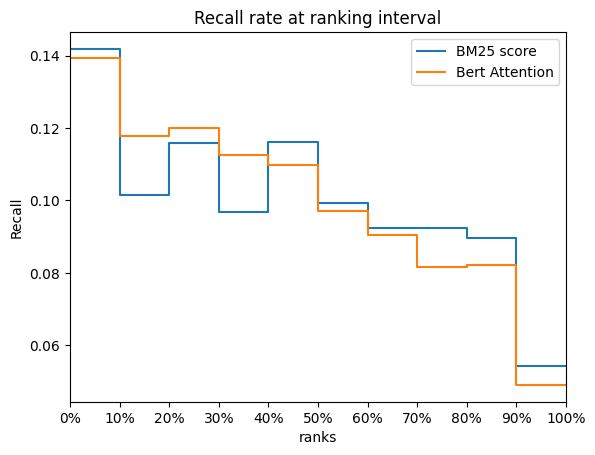

In [12]:
xpoints,ybm25=generate(bins,BM25_Recall)
xpoints,yattention=generate(bins,attention_Recall)
#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, ybm25,label="BM25 score")
ax.plot(xpoints, yattention,label="Bert Attention")

ax.set_xlim(0,1)#x轴从1到7.1
ax.set_title("Recall rate at ranking interval")
ax.set_xlabel("ranks")
ax.set_ylabel("Recall")


xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
print(xsticks)
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)

plt.legend()
plt.show()

In [13]:
# get bm25 precision lines

In [14]:
# bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [str(v) for v in bins][1:]
accumulate_rels=[0 for i in range(len(labels))]
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]
        result=annotation.split("<span>")
        spanls=[]
        spanwordls=[]
        for item in result[1:]:
            itemls=item.split("</span>")
            spanls.append(itemls[0])
            tmp= jieba.cut(itemls[0], cut_all=False) 
            tem = " ".join(tmp).split()
            # 去除标注中的标点
            for ws in tem:
                if ws not in puncset:
                    spanwordls.append(ws)
        spanwordset=set(spanwordls) #注意新分的词语不一定在原本的词语列表中
        # print(len(spanwordset))
        wordls=qcorpus[str(qid)] #wordls是完整的对query分词结果，没有做停用词处理;但是没有标点符号
        ws=Counter(wordls)
        bm25weightspan={}
        bm25weightdic=bm25_dic[str(qid)] #包含bm25对所有词语的重要性
        
        for tok in ws:
            if tok not in bm25weightdic:
                continue
            bm25weightspan[tok]=bm25weightdic[tok]
            
        rankres=sorted(bm25weightspan.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for idx,entry in enumerate(rankres):
            rankdic[entry[0]]=idx
        annot_pos=[]
        for tok in spanwordset:
            if tok not in rankdic:
                continue
            annot_pos.append(rankdic[tok]/len(rankdic)) 
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ntotal_cutbins(annot_pos,bins,labels,len(ws))
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v
print(accumulate_rels)

for idx,v in enumerate(accumulate_rels):
    accumulate_rels[idx]=v/len(dirs)

bm25_presion=accumulate_rels


182
97
173
84
63
86
75
59
117
84
134
65
83
27
147
161
167
77
74
116
73
105
135
45
92
145
171
227
74
51
181
176
70
100
140
104
89
122
88
56
153
73
72
130
52
192
175
92
123
94
83
100
135
182
135
137
202
185
109
105
131
117
207
94
256
209
238
125
143
92
113
132
82
111
84
86
47
164
64
77
120
70
113
285
231
192
133
103
106
240
151
139
134
56
84
69
97
125
137
157
91
117
62
194
79
63
89
[27.89995419940477, 19.800073879425952, 23.880730459348253, 20.705059485526004, 24.328960576857348, 19.834424243483856, 19.341156124339708, 20.342055598828388, 18.19429452981346, 12.041780310609004]


# get the attention weights

In [15]:
queryroot="./annot"

query_p="query.json"
doc2q_p="./atten_new/doc2q_char.json"
attmap_p="./atten_new/atten_map_6_6.pkl"
query_offset_p="./atten_new/query_offset.pkl"

def create_df(annot_pos): 
    df = pd.DataFrame({'score': np.array(annot_pos)}) 
    return df 

dirs=os.listdir(queryroot)
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [str(v) for v in bins][1:]
accumulate_rels=[0 for i in range(len(labels))]

for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]

        label=labelgen(annotation) #原始query的label,不含有;
        origintext=qdict[qid] #原始query
        transdoc=doc2q[str(qid)] # tokenization后还原,含CLS、SEP
        attention=attmap[str(qid)] #attenion map: cls视野下从cls到sep-1的位置
        offsets=query_offset[str(qid)]
        qpos=qcorpus[str(qid)]
        
        attw=attwordana(label,offsets[1:],attention[1:]) # attention weights不包含CLS tokens;
        offsetsls=wordoffsets(qpos,origintext)

        wordattention={} # word index in wordls
        for index,(b,e) in enumerate(offsetsls):
            if b==-1 and e==-1:
                continue
            if b >= len(attw) or e>=len(attw):
                break
            attenw=0
            charcount=0
            for i in range(b,e):
                if i >=len(attw):
                    break
                attenw+=attw[i]
                charcount+=1
            if charcount!=0:
                attenw/=charcount # we count average attention
            wordattention[index]=attenw
        finalindex=index
        
        rankres=sorted(wordattention.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for rank,entry in enumerate(rankres):
            rankdic[entry[0]]=rank # entry means the index of wordls;charindex:rank
        annot_pos=[]

        for wordidx in rankdic:
            # if any label fell into the word offset,we think it is important words;
            b,e=offsetsls[wordidx]
            wordimpflag=False
            for i in range(b,e):
                if label[i]==1:
                    wordimpflag=True
                    continue
            if wordimpflag:
                annot_pos.append(rankdic[wordidx]/len(rankres))

        if len(annot_pos)==0:
            # print(qid)
            continue # means the label not in the truc part
        print(qid)
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ntotal_cutbins(annot_pos,bins,labels,finalindex)
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v
        
for idx,v in enumerate(accumulate_rels):
    accumulate_rels[idx]=v/len(dirs)

attention_precision=accumulate_rels

-1071
89
-3859
110
-5180
109
-743
99
-991
111
0
103
1
104
10
72
11
104
12
105
13
113
1325
79
14
28
1405
107
1430
90
15
116
16
101
17
109
18
113
19
107
1972
103
2
47
20
105
2132
109
2174
93
2186
54
2198
87
2203
93
221
93
23
101
2331
102
2361
100
2373
101
2387
91
24
77
2403
87
2430
91
25
95
259
99
26
63
27
108
28
102
29
105
3228
102
330
94
3342
104
3746
113
3765
87
3814
96
3817
91
3862
102
3878
110
3943
105
3952
102
4
101
4023
110
4719
105
4829
103
4847
93
4863
104
4873
98
4891
100
5
100
5156
103
5187
104
5193
103
5223
56
5239
104
5504
82
5511
94
5561
107
6
81
6046
102
6081
109
6094
96
6282
103
6394
87
6409
92
6432
102
6652
108
6700
109
6706
97
6775
62
6816
97
6820
77
6905
105
6909
109
6917
101
7
109
706
96
8
92
836
107
837
102
861
98
883
101
9
105


['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']


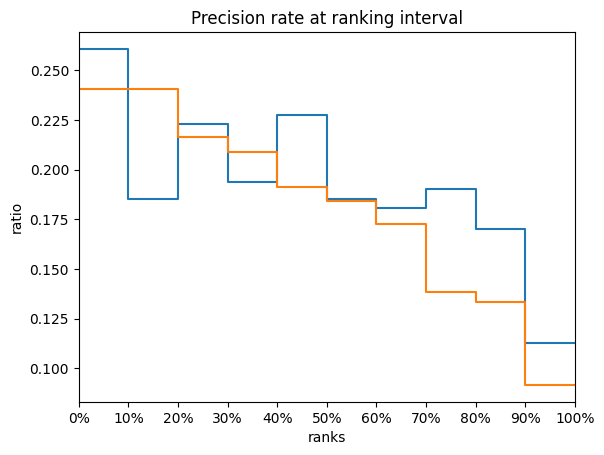

<Figure size 640x480 with 0 Axes>

In [16]:
xpoints,ybm25=generate(bins,bm25_presion)
xpoints,yatte=generate(bins,attention_precision)
#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, ybm25,label="BM25 score")
ax.plot(xpoints, yatte,label="Bert Attention")

ax.set_xlim(0,1)#x轴从1到7.1
ax.set_title("Precision rate at ranking interval")
ax.set_xlabel("ranks")
ax.set_ylabel("ratio")
xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
print(xsticks)
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)

plt.show()
plt.clf()
## 1. 标注本身的TF-IDF值

['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100']
[0.14187491 0.10162124 0.11592919 0.09684085 0.11609179 0.09920989
 0.09236978 0.09240552 0.08949528 0.05416153]
[0.13925179 0.11780325 0.12002398 0.11262878 0.10993424 0.09710258
 0.09053343 0.08163928 0.08205489 0.04902778]
['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100']


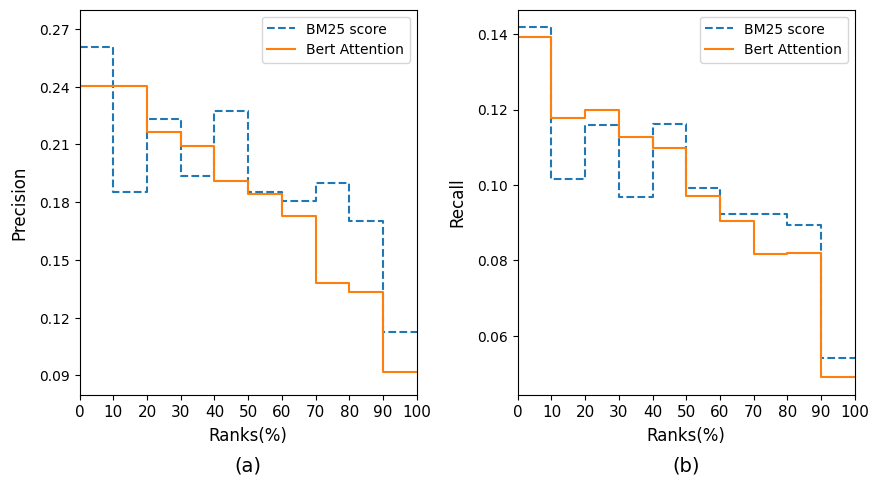

In [20]:
xpoints,ybm25=generate(bins,bm25_presion)
xpoints,yatte=generate(bins,attention_precision)
#设置刻度范围
fig=plt.figure(num=1,figsize=(10,5))
ax=plt.subplot(121)
ax.plot(xpoints, ybm25,label="BM25 score",linestyle='--')
ax.plot(xpoints, yatte,label="Bert Attention",linestyle='-')

ax.set_xlim(0,1)#x轴从1到7.1
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.03)) # 标签数据间隔;
ax.set_ylim(0.08,0.28)#x轴从1到7.1

# ax.set_title("Precision rate at ranking interval")
ax.set_xlabel("Ranks(%)",fontsize=12,labelpad=5)
ax.set_ylabel("Precision",fontsize=12,labelpad=8)
# xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
xsticks=[str(int(x)) for x in np.linspace(0,100,len(bins))]
ax.set_title("(a)", y=-0.22, fontsize=14)
print(xsticks)
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks,fontsize=11) # rotation=45

plt.legend()
xpoints,ybm25=generate(bins,BM25_Recall)
print(BM25_Recall)
xpoints,yattention=generate(bins,attention_Recall)
print(attention_Recall)

#设置刻度范围
ax=plt.subplot(122)
ax.plot(xpoints, ybm25,label="BM25 score",linestyle='--')
ax.plot(xpoints, yattention,label="Bert Attention",linestyle='-')

ax.set_xlim(0,1)#x轴从1到7.1
# ax.set_title("Recall at ranking interval")
ax.set_xlabel("Ranks(%)",fontsize=12,labelpad=5)
ax.set_ylabel("Recall",fontsize=12,labelpad=8)

# xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
xsticks=[str(int(x)) for x in np.linspace(0,100,len(bins))]
print(xsticks)
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks,fontsize=11) #rotation=45
ax.set_title("(b)", y=-0.22, fontsize=14)

plt.legend()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=0.3) # wspace 左右距离;hspace 上下距离
plt.show()
